In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**In this task, I use 15-Scene to train VGG16 from-scretch and pre-trained.And I found that from-scretech is not good even drop in local-minimum situation,I try to run more times and change loss function and learning rate but still not work well ,but for pre-trained is good ,the accuracy is 86% for one time 85%for three time**

# **VGG16---15-Scene dataset**

#  import necessary package and vgg16

In [0]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense,Flatten,Dropout
import cv2
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from tqdm import tqdm_notebook as tqdm 
import os
from keras import optimizers
from keras.callbacks import EarlyStopping


process dataset and split it to training dataset,testing dataset

In [0]:
img_size = 224
num_classes = 15
maxepoches = 30
batch_size = 50

DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/VGG16_Practice/15-Scene'
one_hot_lookup = np.eye(num_classes)
dataset_x = []
dataset_y = []
for category in sorted(os.listdir(DATASET_PATH)):
    for fname in os.listdir(DATASET_PATH+"/"+category):
        img = cv2.imread(DATASET_PATH+"/"+category+'/'+fname, 2)
        img = cv2.resize(img, (img_size,img_size))
        dataset_x.append(np.reshape(img, [img_size,img_size,1]))
        dataset_y.append(np.reshape(one_hot_lookup[int(category)], [num_classes]))




# train_y = keras.utils.to_categorical(train_y).astype('float32')
# test_y = keras.utils.to_categorical(test_y).astype('float32')

In [0]:
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

In [0]:

"""shuffle dataset"""
p = np.random.permutation(len(dataset_x))
dataset_x = dataset_x[p]
dataset_y = dataset_y[p]
        
test_x = dataset_x[:int(len(dataset_x)/10)]
test_y = dataset_y[:int(len(dataset_x)/10)]
train_x = dataset_x[int(len(dataset_x)/10):]
train_y = dataset_y[int(len(dataset_x)/10):]

print train_x  train_y  test_x  test_y shape , founding those part is one channel beacuse they are gray image

In [7]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(4037, 224, 224, 1)
(4037, 15)
(448, 224, 224, 1)
(448, 15)


In order fit with VGG16 network , I convert one channel to three channel 

In [8]:
train_x = [cv2.cvtColor(cv2.resize(i,(224,224)), cv2.COLOR_GRAY2BGR) for i in train_x]
train_x = np.concatenate([arr[np.newaxis] for arr in train_x]).astype('float32')
 
test_x  = [cv2.cvtColor(cv2.resize(i,(224,224)), cv2.COLOR_GRAY2BGR) for i in test_x ]
test_x  = np.concatenate([arr[np.newaxis] for arr in test_x] ).astype('float32')

print("train_x shape :",train_x.shape)
print("test_x shape:",test_x.shape)

train_x shape : (4037, 224, 224, 3)
test_x shape: (448, 224, 224, 3)


In [0]:
train_x /= 255
test_x /= 255

# **VGG16 from Scretch**

This part is VGG16 from scrtech : weights=None and layer.trainable=True 

In [10]:

model_vgg =VGG16(include_top=False,input_shape=(224,224,3),weights=None)
for layer in model_vgg.layers:
  layer.trainable=True
#model=Flatten(name='Flatten')(model_vgg.output)
x = model_vgg.get_layer('block5_pool').output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(15, activation='softmax', name='predictions')(x)


In [11]:
#model=Dense(15,activation='softmax')(model)
model_vgg_scene=Model(inputs=model_vgg.input, outputs=x)
model_vgg_scene.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
def learning_rate_schedule(epoch):
    if epoch <= 10:
        return 1e-4 # 0.00001
    elif epoch <= 20:
        return 1e-5
    elif epoch <= 30:
        return 1e-6
    else:
        return 1e-7
    return LR

In [0]:
#sgd=SGD(lr=0.05,decay=1e-5)

In [14]:
model_vgg_scene.compile(loss='categorical_crossentropy',optimizer=optimizers.sgd(lr=0.0001),metrics = ['accuracy'])

In [15]:
keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [16]:
history=model_vgg_scene.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=32,shuffle=True, verbose=1, epochs=maxepoches)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4037 samples, validate on 448 samples
Epoch 1/30





4037/4037 [==============================] - 133s 33ms/step - loss: 2.7080 - acc: 0.0681 - val_loss: 2.7080 - val_acc: 0.0826
Epoch 2/30
4037/4037 [==============================] - 114s 28ms/step - loss: 2.7080 - acc: 0.0917 - val_loss: 2.7079 - val_acc: 0.1228
Epoch 3/30
4037/4037 [==============================] - 114s 28ms/step - loss: 2.7079 - acc: 0.0919 - val_loss: 2.7078 - val_acc: 0.1161
Epoch 4/30
4037/4037 [==============================] - 114s 28ms/step - loss: 2.7078 - acc: 0.0914 - val_loss: 2.7077 - val_acc: 0.1183
Epoch 5/30
4037/4037 [==============================] - 114s 28ms/step - loss: 2.7078 - acc: 0.0914 - val_loss: 2.7076 - val_acc: 0.1183
Epoch 6/30
4037/4037 [==============================] - 114s 28ms/step - loss: 2.7077 - acc: 0.0912 - val_loss: 2.7076 - val_acc: 0.1183
Epoch 7/30
4037/4037 [=======

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from keras import optimizers
from keras.callbacks import EarlyStopping


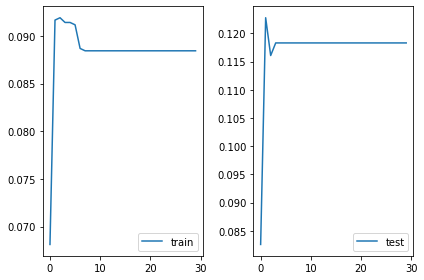

In [18]:

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.legend(['train'], loc='lower right')
plt.subplot(1, 2, 2)

plt.plot(history.history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.tight_layout() 

plt.show()


# **VGG16 Pre-trained**

This part using Pre-trained model ,and I design two parts. First is run 1 times and second is run 3 times .it is clearly that perform one times the accuracy increase a lot, even perform three times the model drop in local-minium

# **Perform Training one times**

**By using VGG16 pre-trained model run one time ,the accuracy increased to 78.1%**

In [19]:
ishape=224
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(ishape, ishape, 3))
for layer in model_vgg.layers:
    layer.trainable = False


58892288/58889256 [==============================] - 3s 0us/step


In [0]:
x = model_vgg.get_layer('block5_pool').output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(15, activation='softmax', name='predictions')(x)


In [21]:
#model=Dense(15,activation='softmax')(model)
model_vgg_pre_scene=Model(inputs=model_vgg.input, outputs=x)
model_vgg_pre_scene.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# model = Dense(15, activation="softmax")(model)
# model_vgg_scene_pretrain = Model(model_vgg.input, model, name='vgg_16_pretrain')
# model_vgg_scene_pretrain.summary()

In [0]:
def learning_rate_schedule(epoch):
    if epoch <= 10:
        return 1e-4 # 0.00001
    elif epoch <= 20:
        return 1e-5
    elif epoch <= 30:
        return 1e-6
    else:
        return 1e-7
    return LR

In [0]:
#sgd = SGD(lr = 0.01, decay = 1e-5)
model_vgg_pre_scene.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(lr=0.0001), metrics = ['accuracy'])

In [25]:
keras.callbacks.LearningRateScheduler(learning_rate_schedule)

In [26]:
model_vgg_pre_scene.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=32, shuffle=True, verbose=1, epochs=10)

Train on 4037 samples, validate on 448 samples
Epoch 1/10
4037/4037 [==============================] - 44s 11ms/step - loss: 1.0449 - acc: 0.6757 - val_loss: 0.5533 - val_acc: 0.7835
Epoch 2/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.3380 - acc: 0.8922 - val_loss: 0.4819 - val_acc: 0.8348
Epoch 3/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.1855 - acc: 0.9403 - val_loss: 0.4864 - val_acc: 0.8170
Epoch 4/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.0925 - acc: 0.9755 - val_loss: 0.4586 - val_acc: 0.8482
Epoch 5/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.0614 - acc: 0.9854 - val_loss: 0.4389 - val_acc: 0.8594
Epoch 6/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.0324 - acc: 0.9916 - val_loss: 0.4209 - val_acc: 0.8750
Epoch 7/10
4037/4037 [==============================] - 43s 11ms/step - loss: 0.0238 - acc: 0.9946 - val_loss: 0.4572 - val_acc: 0.8638
E

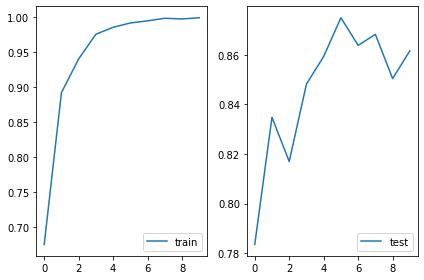

In [27]:
plt.subplot(1, 2, 1)
plt.plot(model_vgg_pre_scene.history.history['acc'])
plt.legend(['train'], loc='lower right')
plt.subplot(1, 2, 2)

plt.plot(model_vgg_pre_scene.history.history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.tight_layout() 

plt.show()


# **Perform Training Three Times**

The code which show below is not good way to normlization data in this dataset

In [0]:
# from tensorflow.keras.applications.vgg16 import preprocess_input
# x_test = preprocess_input(test_x)
# x_train = preprocess_input(train_x)

In [29]:
ishape=224

model = VGG16(weights='imagenet', include_top=False, input_shape=(ishape, ishape, 3))
for layer in model_vgg.layers:
    layer.trainable = False
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from keras.layers import Flatten, Dense
from keras.models import Model

x = model.get_layer('block5_pool').output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
#x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(15, activation='softmax', name='predictions')(x)

model_pre_updated = Model(inputs=model.input, outputs=x)

In [0]:
def learning_rate_schedule(epoch):
    if epoch <= 10:
        return 1e-4 # 0.00001
    elif epoch <= 20:
        return 1e-5
    elif epoch <= 30:
        return 1e-6
    else:
        return 1e-7
    return LR

In [0]:
model_pre_updated.save_weights('model_initial.h5')

In [33]:
from keras import optimizers
from keras.callbacks import EarlyStopping

model_pre_updated.save_weights('model_initial.h5')
training_runs = []
for i in range(3):
    #model_updated.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    model_pre_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(lr=0.0001), metrics=['accuracy'])
    keras.callbacks.LearningRateScheduler(learning_rate_schedule)
    history = model_pre_updated.fit(train_x, train_y, batch_size=32,  shuffle=True,verbose=1, epochs=10, validation_data=(test_x, test_y))
    training_runs.append(history)
    model_pre_updated.get_weights()
    if i == 2:
        model_pre_updated.save_weights('model1.h5')
    else:
        model_pre_updated.load_weights('model_initial.h5')
    print()

Train on 4037 samples, validate on 448 samples
Epoch 1/10
4037/4037 [==============================] - 119s 29ms/step - loss: 1.0252 - acc: 0.6554 - val_loss: 0.6536 - val_acc: 0.7656
Epoch 2/10
4037/4037 [==============================] - 118s 29ms/step - loss: 0.4258 - acc: 0.8556 - val_loss: 0.5316 - val_acc: 0.8058
Epoch 3/10
4037/4037 [==============================] - 118s 29ms/step - loss: 0.2794 - acc: 0.9009 - val_loss: 0.7661 - val_acc: 0.7545
Epoch 4/10
4037/4037 [==============================] - 117s 29ms/step - loss: 0.2117 - acc: 0.9289 - val_loss: 0.4589 - val_acc: 0.8393
Epoch 5/10
4037/4037 [==============================] - 117s 29ms/step - loss: 0.1320 - acc: 0.9562 - val_loss: 0.6158 - val_acc: 0.8237
Epoch 6/10
4037/4037 [==============================] - 117s 29ms/step - loss: 0.0958 - acc: 0.9693 - val_loss: 0.5353 - val_acc: 0.8348
Epoch 7/10
4037/4037 [==============================] - 117s 29ms/step - loss: 0.0789 - acc: 0.9710 - val_loss: 0.6736 - val_acc: 0

In [0]:
import matplotlib.pyplot as plt
import numpy as np

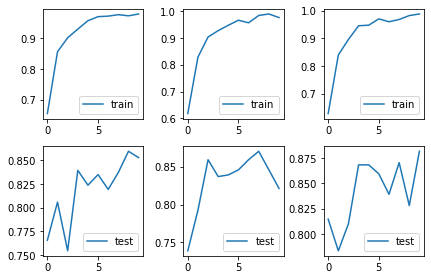

Average training accuracy: 0.9805961522631992
Average testing accuracy: 0.8519345238095237


In [35]:
plt.subplot(2, 3, 1)
plt.plot(training_runs[0].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(training_runs[1].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 3)
plt.plot(training_runs[2].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 4)
plt.plot(training_runs[0].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(training_runs[1].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(training_runs[2].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.tight_layout() 

plt.show()

print("Average training accuracy: {}".format(np.mean([training_runs[0].history['acc'][-1], 
                                                     training_runs[1].history['acc'][-1], training_runs[2].history['acc'][-1]])))
print("Average testing accuracy: {}".format(np.mean([training_runs[0].history['val_acc'][-1], 
                                                     training_runs[1].history['val_acc'][-1], training_runs[2].history['val_acc'][-1]])))